The general purpose of this exercise is to forecast future atmopsheric carbon dioxide concentration by fitting a model to observations that have been collected by the U.S. National Oceanic and Atmospheric Administration (NOAA) since 1958 at the Mauna Loa Observatory in Hawaii.

In simple terms, the Earth receives energy from the sun in the form of sunlight. Some of this energy is absorbed by the Earth's surface, and some is reflected back into space. Carbon dioxide and other gases in the Earth's atmosphere trap some of this ongoing radiation, preventing it from escaping into space and essentially acting like a blanket around the Earth.

Source: https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


## Read and explore dataset

In [2]:
# Define dataset column names
col_names = ['year','month','decimal_date','monthly_avg_co2',
             'de_seasonalized','days','std','uncertainty']

# Load data
df = pd.read_csv('../datasets/co2_mm_mlo.txt', comment='#', delimiter='\s+', names=col_names)
df.head(5)


,year,month,decimal_date,monthly_avg_co2,de_seasonalized,days,std,uncertainty
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


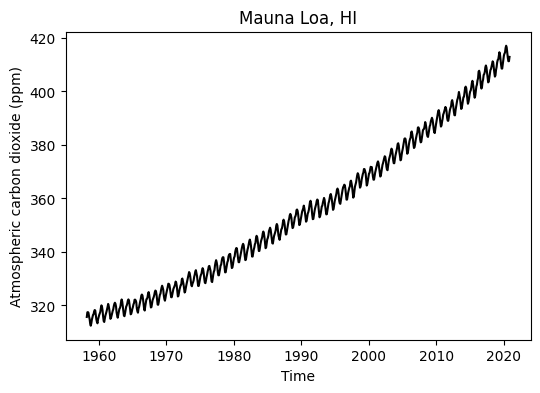

In [3]:
# Visualize observed data
plt.figure(figsize=(6,4))
plt.plot(df['decimal_date'], df['monthly_avg_co2'], '-k')
plt.title('Mauna Loa, HI')
plt.xlabel('Time')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.show()


## Split dataset into train and test sets

This separation will allow us to fit the model to a larger portion of the dataset and then test it against some unseen data points by the model.

In [4]:
# Split dataset into train and test sets
idx_train = df['year'] < 2017
df_train = df[idx_train]
df_test = df[~idx_train]

# Create shorter names for the dependent and independent variables
start_date = df_train["decimal_date"][0]
x_train = df_train["decimal_date"] - start_date # Dates relative to first date
y_train = df_train['monthly_avg_co2']

x_test = df_test["decimal_date"] - start_date # Dates relative to first date
y_test = df_test['monthly_avg_co2']


## Determine trend of time series

To capture the main trend of carbon dioxide concentration over time we will fit the following exponential model:

$$y(t) = a + b \ exp \bigg(\frac{c \ t}{d}\bigg)$$

$t$ is time since March, 1958 (the start of the data set)<br>
$a$, $b$, $c$, and $d$ are unknown parameters.

In [5]:
# Define lambda function
exp_model = lambda t,a,b,c,d: a + b*np.exp(c*t/d)


In [7]:
# Fit exponential model
exp_par = curve_fit(exp_model, x_train, y_train)

# Display parameters
print('a:', exp_par[0][0])
print('b:', exp_par[0][1])
print('c:', exp_par[0][2])
print('d:', exp_par[0][3])


a: 255.96961561849702
b: 57.671516523308355
c: 0.016585403165490224
d: 1.0298254042563226


In [28]:
# Predict CO2 concentration using exponential model
y_train_exp = exp_model(x_train, *exp_par[0])


In [53]:
# Define lambda function for the mean absolute error formula
mae_fn = lambda obs,pred: np.mean(np.abs(obs - pred))

# Compute MAE between observed and predicted carbon dioxide using the expoential model
mae_train_exp = mae_fn(y_train, y_train_exp)
print('MAE using the exponential model is:',np.round(mae_train_exp, 2), 'ppm')


MAE using the exponential model is: 1.87 ppm


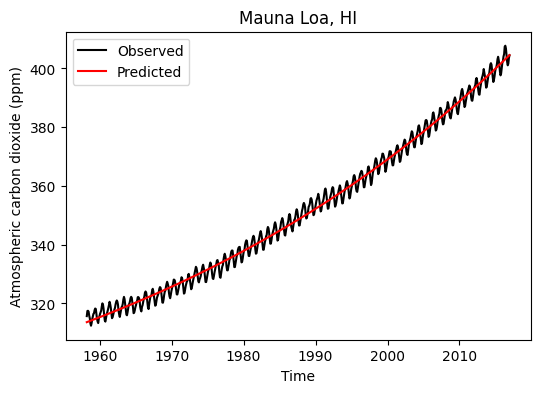

In [55]:
# Overlay obseved and predicted carbon dioxide
plt.figure(figsize=(6,4))
plt.plot(df_train['decimal_date'], y_train, '-k', label='Observed')
plt.plot(df_train['decimal_date'], y_train_exp, '-r', label='Predicted')
plt.title('Mauna Loa, HI')
plt.xlabel('Time')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.legend()
plt.show()


### Examine residuals of exponential fit

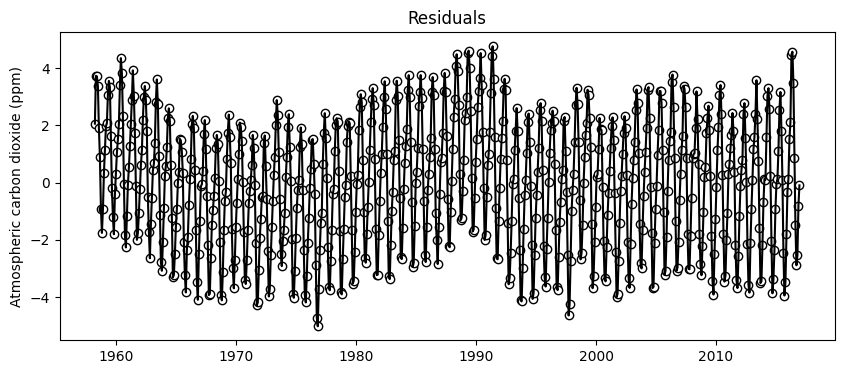

In [56]:
# Compute residuals
residuals_exp_fit = y_train - y_train_exp

# Generate scatter plot.
# We will also add a line plot to better see any temporal trends
plt.figure(figsize=(10,4))
plt.scatter(df_train['decimal_date'],residuals_exp_fit, facecolor='w', edgecolor='k')
plt.plot(df_train['decimal_date'],residuals_exp_fit, color='k')
plt.title('Residuals')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.show()


In [33]:
# Check if residuals approach a zero mean
print('Mean residuals (ppm):', np.mean(residuals_exp_fit))


Mean residuals (ppm): -4.931054212049981e-06


Residuals exhibit a mean close to zero and a sinusoidal pattern. This suggests that a model involving sine or cosine terms could be used to add to improve the exponential model predictions.

## Determine seasonality of time series

To determine the seasonality of the data we will use the de-trended residuals.

$$y(t) = A \ sin(2 \pi [m + phi] )$$


$t$ is time since March, 1958 (the start of the data set)<br>
$A$ is amplitude of the wave<br>
$m$ is the fractional month (Jan is zero and Dec is 1)<br>
$phi$ is the phase constant


In [34]:
# Define the sinusoidal model
sin_model = lambda t,A,phi: A*np.sin(2*np.pi*((t-np.floor(t)) + phi))

# Fit sinusoidal-exponential model
p0 = [-3, -10]
sin_par = curve_fit(sin_model, x_train, y_train, p0)

# Display parameters
print('A:', sin_par[0][0])
print('phi:', sin_par[0][1])


A: 2.9614562555902526
phi: -9.921208441996372


In [35]:
# Generate timeseries using sinusoidal-exponential model
y_train_sin = sin_model(x_train, *sin_par[0])


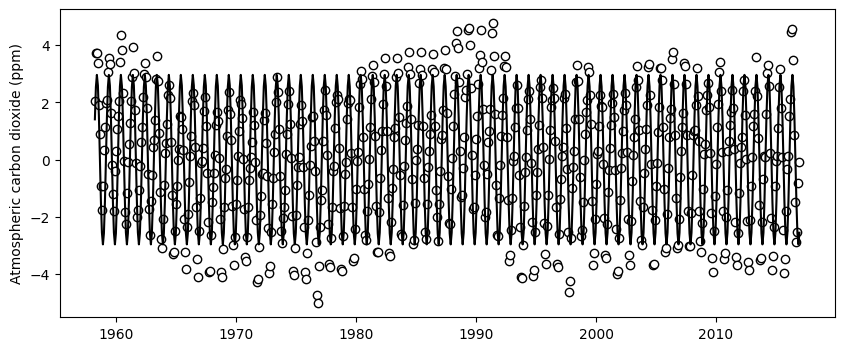

In [57]:
# Visualize residuals of the exponential fit and the fitted sinusoidal model
plt.figure(figsize=(10,4))
plt.scatter(df_train['decimal_date'], residuals_exp_fit, facecolor='w', edgecolor='k')
plt.plot(df_train['decimal_date'], y_train_sin, '-k')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.show()


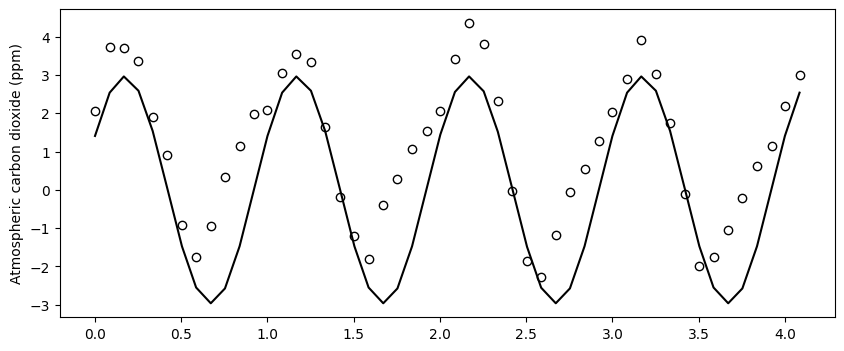

In [37]:
# Close up view for a shorter time span of 50 months
zoom_range = range(0,50)
plt.figure(figsize=(10,4))
plt.scatter(x_train[zoom_range], residuals_exp_fit[zoom_range],
            facecolor='w', edgecolor='k')
plt.plot(x_train[zoom_range], y_pred_sin[zoom_range], '-k')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.show()

Althought we can still some minor differences, overall the sinnusoidal model seems to capture the main trend of the residuals. We could compute the residuals of this fit to inspect if there still is a trend that we can exploit to include in our model. In this exercise we will stop here, since this is probably sufficient for most practical applications, but before we move on, let's plot the residuals of the sinusoidal fit. You will see that slowly the residuals are looking more random.


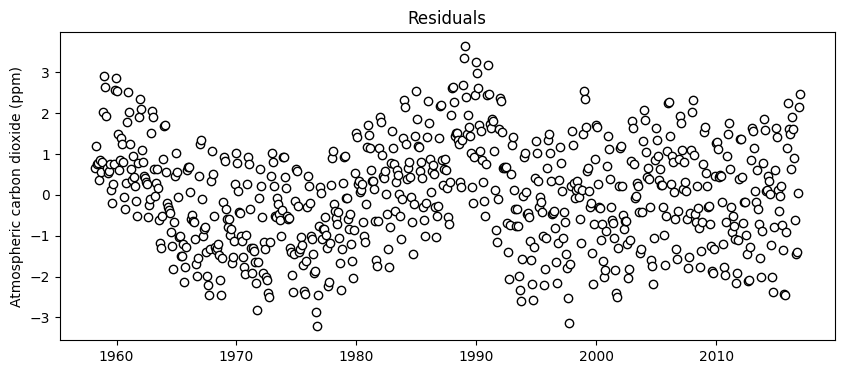

In [58]:
# Calculate residuals
residuals_sin_fit = residuals_exp_fit - y_train_sin

# Plot
plt.figure(figsize=(10,4))
plt.scatter(df_train['decimal_date'], residuals_sin_fit, facecolor='w', edgecolor='k')
plt.title('Residuals')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.show()


## Combine trend and seasonal models

Now that we have an exponential and a sinusoidal model, let's combine them to have a full deterministic model that we can use to predict and forecast the atmospheric carbon dioxide concentration. The combined model is:

$$y(t) = a + b \ exp \bigg(\frac{c \ t}{d}\bigg) + A \ sin(2 \pi [m + phi] )$$


In [20]:
# Define the exponential-sinusoidal model
exp_sin_model = lambda t,a,b,c,d,A,phi: a+b*np.exp(c*t/d) + A*np.sin(2*np.pi*((t-np.floor(t))+phi))


In [21]:
# Recall that the parameters for the exponential and sinnusoidal models are:
print(exp_par[0])
print(sin_par[0])


[2.55969616e+02 5.76715165e+01 1.65854032e-02 1.02982540e+00]
[ 2.96145626 -9.92120844]


In [22]:
# So the combined parameters for both models are
exp_sin_par = np.concatenate((exp_par[0], sin_par[0]))


In [45]:
# Predict the time series using the full model
y_train_exp_sin = exp_sin_model(x_train, *exp_sin_par)


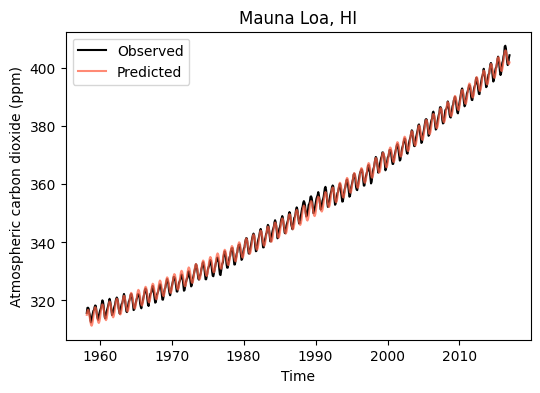

In [59]:
# Create figure of combined models
plt.figure(figsize=(6,4))
plt.plot(df_train['decimal_date'], y_train, '-k', label='Observed')
plt.plot(df_train['decimal_date'], y_train_exp_sin, 
         color='tomato', alpha=0.75, label='Predicted')
plt.title('Mauna Loa, HI')
plt.xlabel('Time')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.legend()
plt.show()


In [52]:
# Compute MAE of combined model against the training set
mae_train_exp_sin = mae_fn(y_train, y_train_exp_sin)
print('MAE using the exponential-sinusoidal model is:',np.round(mae_train_exp_sin, 2), 'ppm')


MAE using the exponential-sinusoidal model is: 1.05 ppm


Text(0, 0.5, 'Atmospheric carbon dioxide (ppm)')

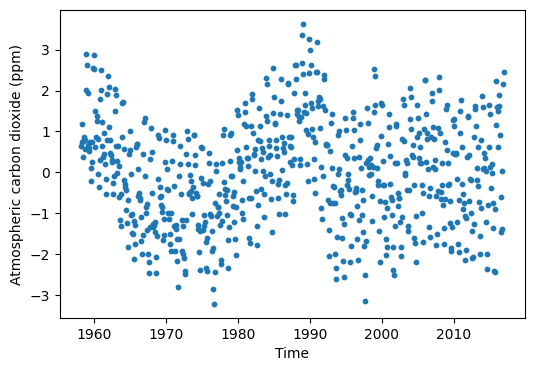

In [60]:
# Compute residuals
residuals_exp_sin = y_train - y_train_exp_sin

# Plot residuals
plt.figure(figsize=(6,4))
plt.scatter(df_train['decimal_date'], residuals_exp_sin, s=10)
plt.xlabel('Time')
plt.ylabel('Atmospheric carbon dioxide (ppm)')


## Full model against test set

In [51]:
# Predict the time series using the full model
y_test_exp_sin = exp_sin_model(x_test, *exp_sin_par)

# Compute MAE of combined model against the test set
mae_test_exp_sin = mae_fn(y_test, y_test_exp_sin)
print('MAE using the exponential-sinusoidal model is:',np.round(mae_test_exp_sin, 2), 'ppm')


MAE using the exponential-sinusoidal model is: 1.16 ppm


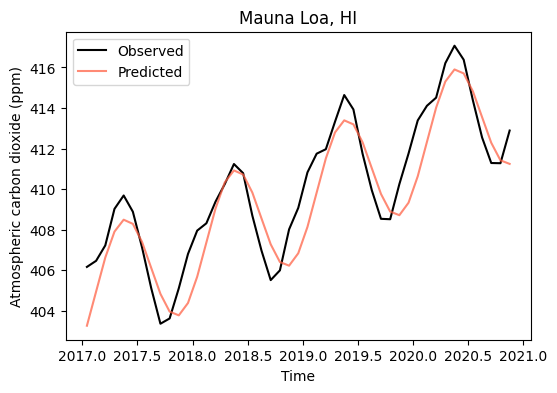

In [61]:
# Create figure of combined models
plt.figure(figsize=(6,4))
plt.plot(df_test['decimal_date'], y_test, '-k', label='Observed')
plt.plot(df_test['decimal_date'], y_test_exp_sin, color='tomato', alpha=0.75, label='Predicted')
plt.title('Mauna Loa, HI')
plt.xlabel('Time')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.legend()
plt.show()

## Generate 2030 forecast 

In [62]:
# Forecast of concentration in 2030 (here we only need the relative year value in 2030)
y_2030 = exp_sin_model(2030 - start_date, *exp_sin_par)
print('Carbon dioxide concentration in 2050 is estimated to be:', np.round(y_2030),'ppm')


Carbon dioxide concentration in 2050 is estimated to be: 437.0 ppm


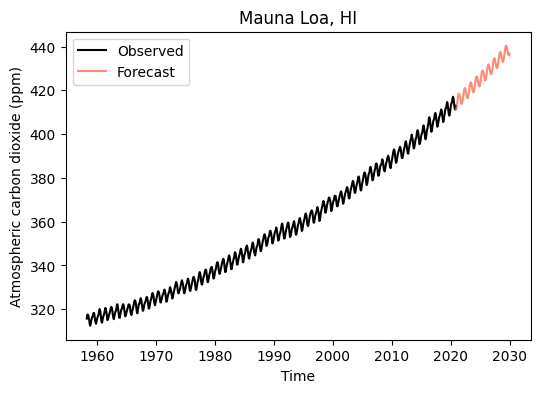

In [66]:
last_date = df['decimal_date'].iloc[-1]
x_forecast = np.arange(last_date, 2030, 0.1) - start_date
y_forecast = exp_sin_model(x_forecast, *exp_sin_par)

# Figure with projection
plt.figure(figsize=(6,4))
plt.plot(df['decimal_date'], df['monthly_avg_co2'], '-k', label='Observed')
plt.plot(start_date+x_forecast, y_forecast, color='tomato', alpha=0.75, label='Forecast')
plt.title('Mauna Loa, HI')
plt.xlabel('Time')
plt.ylabel('Atmospheric carbon dioxide (ppm)')
plt.legend()
plt.show()


## Practice

1. Based on the mean absolute error, what was the error reduction between the model with a trend term alone vs the model with a trend and seasonal terms? Was it worth it? In what situations would you use one or the other?

2. Are there any evident trends in the residuals after fitting the sinusoidal model?

3. What are possible causes of discrepancy between observations of atmospheric carbon dioxide at the Mauna Loa observatory and our best exponential-sinusoidal model?

4. Try the same exercise using the Bokeh plotting library, so that you can zoom in and inpsect the fit between the model and observations for specific periods.

## References

Data source: https://www.esrl.noaa.gov/gmd/ccgg/trends/full.html

NOAA Greenhouse Gas Marine Boundary Layer Reference: https://www.esrl.noaa.gov/gmd/ccgg/mbl/mbl.html

Mathworks documentation: https://www.mathworks.com/company/newsletters/articles/atmospheric-carbon-dioxide-modeling-and-the-curve-fitting-toolbox.html